# BETH Dataset EDA

>The BETH dataset currently represents 8,004,918 events collected over 23 honeypots, running for about five noncontiguous hours on a major cloud provider. For benchmarking and discussion, we selected the initial subset of the process logs. This subset was further divided into training, validation, and testing sets with a rough 60/20/20 split based on host, quantity of logs generated, and the activity logged—only the test set includes an attack
>
>The dataset is composed of two sensor logs: kernel-level process calls and network traffic. The initial benchmark subset only includes process logs. Each process call consists of 14 raw features and 2 hand-crafted labels.

This notebook is focused solely on the the network-traffic  data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # viz
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple
from glob import glob
import networkx as nx
import ipaddress
from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx
from bokeh.io import output_file,show,output_notebook,push_notebook
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool)
from bokeh.palettes import Spectral4


import warnings
warnings.filterwarnings('ignore')

output_notebook()

# import holoviews as hv
# from holoviews import opts
# hv.extension('bokeh')


Loading BokehJS ...

# Initial Explore
## Load Data
### Analysing for IP 10-100-1-105

In [2]:
# dns_data = glob("/kaggle/input/beth-dataset/*-dns.csv")
dns_data = glob("./data/*-dns.csv")

dns_data

['./data/labelled_2021may-ip-10-100-1-95-dns.csv',
 './data/labelled_2021may-ip-10-100-1-4-dns.csv',
 './data/labelled_2021may-ip-10-100-1-105-dns.csv',
 './data/labelled_2021may-ip-10-100-1-26-dns.csv',
 './data/labelled_2021may-ubuntu-dns.csv',
 './data/labelled_2021may-ip-10-100-1-186-dns.csv']

### Loading Network Data

In [7]:
df_all = []
for data in dns_data[3:4]:
    print(data)
    df = pd.read_csv(data,parse_dates=True, squeeze=True)
    df_all.append(df)
df_final = pd.concat(df_all, ignore_index=True)

./data/labelled_2021may-ip-10-100-1-26-dns.csv


In [8]:
df_final.head()

,Timestamp,SourceIP,DestinationIP,DnsQuery,DnsAnswer,DnsAnswerTTL,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
0,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-95,0,0
1,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,['52.95.19.240'],['17'],ssm.us-east-2.amazonaws.com,['IN'],['A'],1,0,0,ip-10-100-1-95,0,0
2,2021-05-16T17:13:14Z,10.100.1.95,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
3,2021-05-16T17:13:14Z,10.100.0.2,10.100.1.95,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['AAAA'],0,0,0,ip-10-100-1-95,0,0
4,2021-05-16T17:13:16Z,10.100.1.186,10.100.0.2,ssm.us-east-2.amazonaws.com,NaN,NaN,ssm.us-east-2.amazonaws.com,['IN'],['A'],0,0,0,ip-10-100-1-186,0,0


In [9]:
df_final.describe()

,NumberOfAnswers,DnsResponseCode,DnsOpCode,sus,evil
count,269.000000,269.000000,269.0,269.000000,269.000000
mean,0.327138,0.066914,0.0,0.078067,0.014870
std,0.817741,0.443845,0.0,0.268777,0.121258
min,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000
max,8.000000,3.000000,0.0,1.000000,1.000000


In [10]:
duplicateRows = df_final[df_final.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(len(duplicateRows))

Duplicate Rows except first occurrence based on all columns are :
10


In [11]:
df_final = df_final.drop_duplicates()

## Load Process Data

In [71]:
# df_process_all = []
# for data in process_data:
#     df_process = pd.read_csv(data,parse_dates=True, squeeze=True)
#     df_process_all.append(df_process)
# df_process_final = pd.concat(df_process_all, ignore_index=True)

# df_process_final = pd.read_csv("../input/beth-dataset/labelled_2021may-ip-10-100-1-105.csv")
df_process_final = pd.read_csv("./data/labelled_2021may-ip-10-100-1-105.csv")

In [72]:
df_process_final.head()

,timestamp,processId,parentProcessId,userId,processName,hostName,eventId,eventName,argsNum,returnValue,args,sus,evil
0,126.233491,1,0,0,systemd,ip-10-100-1-105,1005,security_file_open,4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
1,126.233165,384,1,101,systemd-resolve,ip-10-100-1-105,41,socket,3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
2,126.233559,1,0,0,systemd,ip-10-100-1-105,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 18}, {...",0,0
3,126.233681,1,0,0,systemd,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 18}]",0,0
4,126.233796,384,1,101,systemd-resolve,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 15}]",0,0


In [73]:
df_process_final.describe()

,timestamp,processId,parentProcessId,userId,eventId,argsNum,returnValue,sus,evil
count,409931.000000,409931.000000,409931.000000,409931.000000,409931.000000,409931.000000,409931.000000,409931.000000,409931.000000
mean,9817.251900,7148.470762,3625.497286,16.032854,352.518995,2.821036,18.009114,0.090952,0.013688
std,5423.929523,1828.103464,3095.579891,122.263915,416.111158,1.354708,338.593452,0.287541,0.116191
min,126.233165,1.000000,0.000000,0.000000,3.000000,0.000000,-115.000000,0.000000,0.000000
25%,5045.775591,7452.000000,1237.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,10336.196016,7570.000000,1344.000000,0.000000,257.000000,4.000000,0.000000,0.000000,0.000000
75%,14430.394610,7740.000000,7320.000000,0.000000,1005.000000,4.000000,3.000000,0.000000,0.000000
max,18696.955825,8040.000000,8037.000000,1001.000000,1010.000000,5.000000,32744.000000,1.000000,1.000000


In [74]:
df_process_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409931 entries, 0 to 409930
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   timestamp        409931 non-null  float64
 1   processId        409931 non-null  int64  
 2   parentProcessId  409931 non-null  int64  
 3   userId           409931 non-null  int64  
 4   processName      409931 non-null  object 
 5   hostName         409931 non-null  object 
 6   eventId          409931 non-null  int64  
 7   eventName        409931 non-null  object 
 8   argsNum          409931 non-null  int64  
 9   returnValue      409931 non-null  int64  
 10  args             409931 non-null  object 
 11  sus              409931 non-null  int64  
 12  evil             409931 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 40.7+ MB


## Network Data EDA

Sus and Evil label distribution

<AxesSubplot:title={'center':'Label Frequency for evil label in Dataset'}>

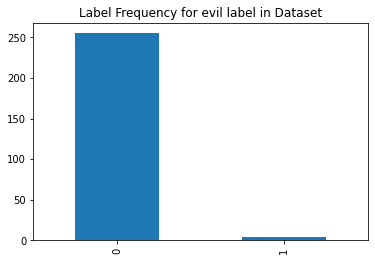

In [75]:
df_final.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Dataset')

<AxesSubplot:title={'center':'Label Frequency for sus label in Dataset'}>

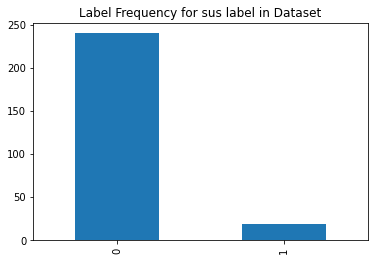

In [76]:
df_final.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Dataset')

In [77]:
df_final.groupby(['sus', 'evil'])[['Timestamp']].count()

Timestamp
sus evil           
0   0           240
1   0            15
    1             4

<AxesSubplot:xlabel='sus,evil'>

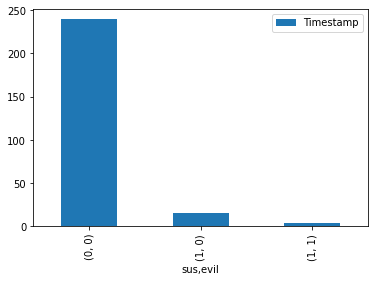

In [78]:
df_final.groupby(['sus', 'evil'])[['Timestamp']].count().plot(kind='bar')

In [79]:
sus_source_ip = df_final[df_final["sus"] == 1]["SourceIP"].unique()
sus_dest_ip = df_final[df_final["sus"] == 1]["DestinationIP"].unique()


These IPs are both source and destination in a suspicious event

In [80]:
set.intersection(set(sus_dest_ip) ,set(sus_source_ip))

{'10.100.0.2', '10.100.1.105', '10.100.1.95'}

### Suspicious Events

<AxesSubplot:xlabel='SourceIP'>

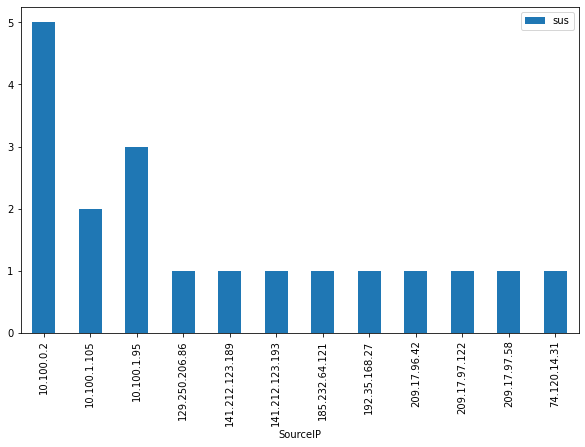

In [81]:
df_final[df_final["sus"] == 1][["SourceIP","sus"]].groupby("SourceIP").sum().plot(kind='bar',figsize=(10, 6))

<AxesSubplot:xlabel='DestinationIP'>

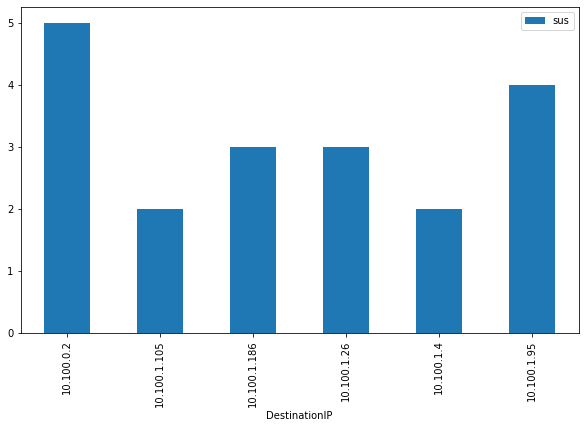

In [82]:
df_final[df_final["sus"] == 1][["DestinationIP","sus"]].groupby("DestinationIP").sum().plot(kind='bar',figsize=(10, 6))

<AxesSubplot:xlabel='DnsQuery'>

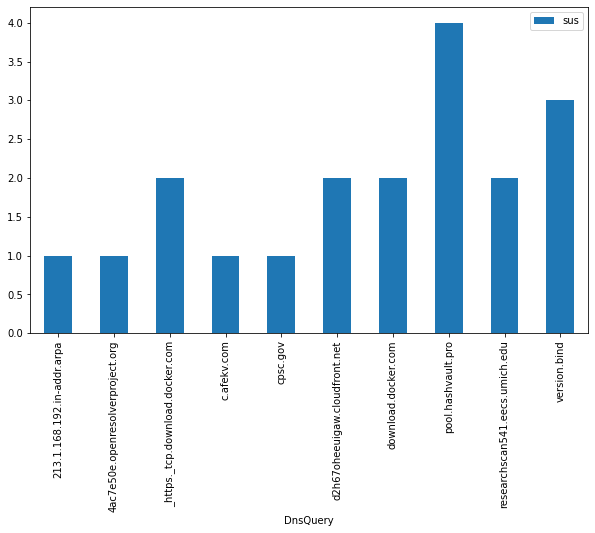

In [83]:
df_final[df_final["sus"] == 1][["DnsQuery","sus"]].groupby("DnsQuery").sum().plot(kind='bar',figsize=(10, 6))

### Evil Events

In [84]:
df_final[df_final["evil"] == 1]

,Timestamp,SourceIP,DestinationIP,DnsQuery,DnsAnswer,DnsAnswerTTL,DnsQueryNames,DnsQueryClass,DnsQueryType,NumberOfAnswers,DnsResponseCode,DnsOpCode,SensorId,sus,evil
220,2021-05-16T21:08:29Z,10.100.1.105,10.100.0.2,pool.hashvault.pro,NaN,NaN,pool.hashvault.pro,['IN'],['A'],0,0,0,ip-10-100-1-105,1,1
221,2021-05-16T21:08:29Z,10.100.1.105,10.100.0.2,pool.hashvault.pro,NaN,NaN,pool.hashvault.pro,['IN'],['AAAA'],0,0,0,ip-10-100-1-105,1,1
222,2021-05-16T21:08:29Z,10.100.0.2,10.100.1.105,pool.hashvault.pro,NaN,NaN,pool.hashvault.pro,['IN'],['AAAA'],0,0,0,ip-10-100-1-105,1,1
223,2021-05-16T21:08:29Z,10.100.0.2,10.100.1.105,pool.hashvault.pro,"['131.153.142.106', '131.153.56.98']","['300', '300']",pool.hashvault.pro,['IN'],['A'],2,0,0,ip-10-100-1-105,1,1


<AxesSubplot:xlabel='SourceIP'>

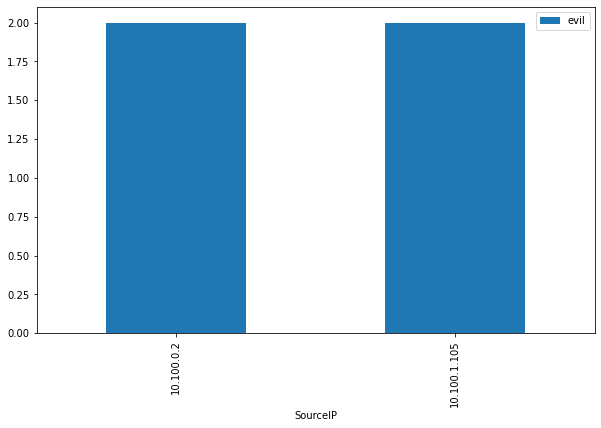

In [85]:
df_final[df_final["evil"] == 1][["SourceIP","evil"]].groupby("SourceIP").sum().plot(kind='bar',figsize=(10, 6))

<AxesSubplot:xlabel='DnsQuery'>

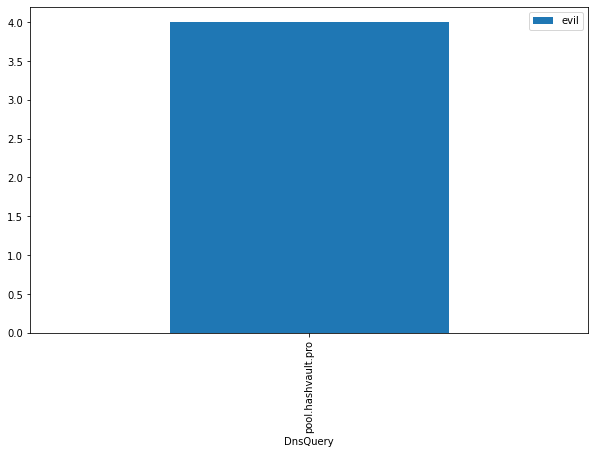

In [86]:
df_final[df_final["evil"] == 1][["DnsQuery","evil"]].groupby("DnsQuery").sum().plot(kind='bar',figsize=(10, 6))

Analysing other features

<AxesSubplot:title={'center':'DnsQueryClass frequency in Dataset'}>

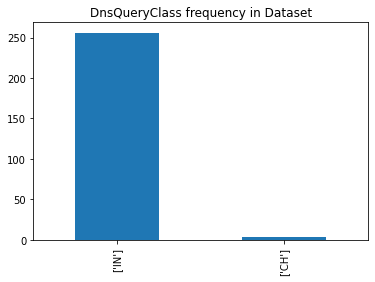

In [87]:
df_final.DnsQueryClass.value_counts().plot(kind='bar', title='DnsQueryClass frequency in Dataset')

<AxesSubplot:title={'center':'DnsQueryType frequency in Dataset'}>

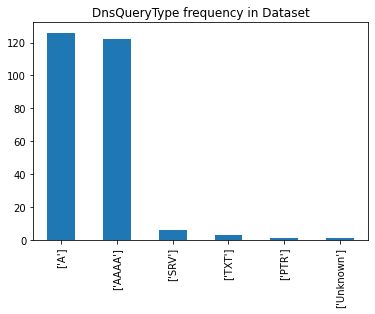

In [88]:
df_final.DnsQueryType.value_counts().plot(kind='bar', title='DnsQueryType frequency in Dataset')

#### Time Series Analysis

<AxesSubplot:>

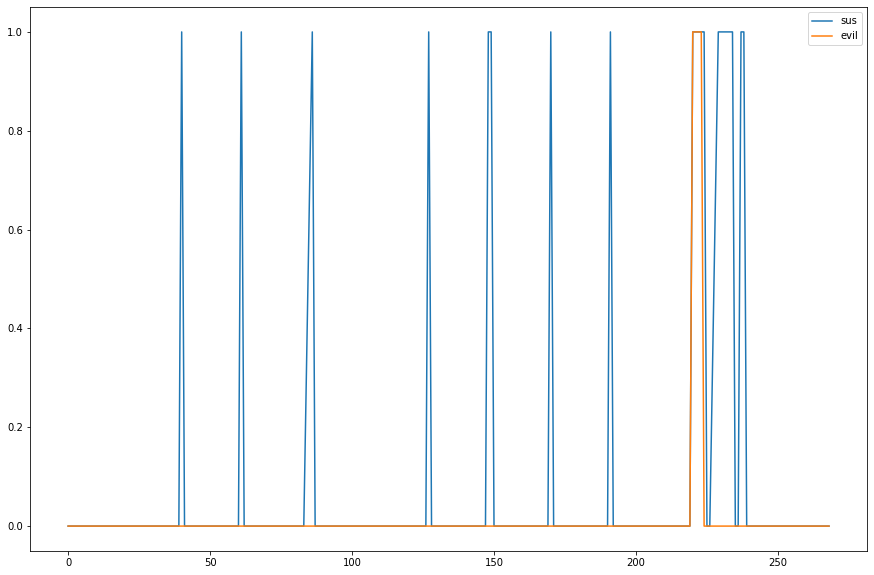

In [89]:
df_final[["sus","evil"]].plot(figsize=(15, 10))

### Plot sum of events for every N sequences

<AxesSubplot:>

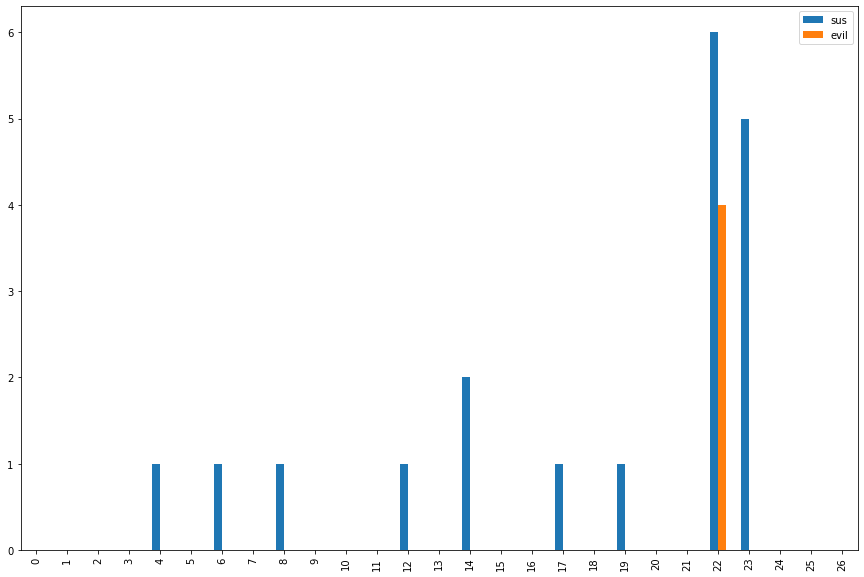

In [90]:
N = 10
df_final[["sus","evil"]].groupby(df_final.index // N).sum().plot(kind='bar',figsize=(15, 10))

## Process Data EDA

<AxesSubplot:title={'center':'Label Frequency for evil label in Dataset'}>

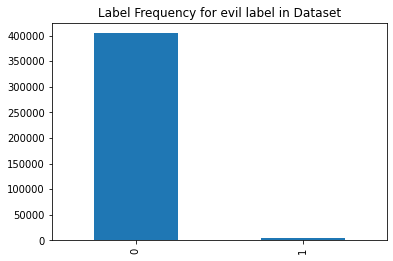

In [91]:
df_process_final.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Dataset')

In [92]:
df_process_final.groupby(['sus', 'evil'])[['timestamp']].count()

timestamp
sus evil           
0   0        372647
1   0         31673
    1          5611

<AxesSubplot:xlabel='sus,evil'>

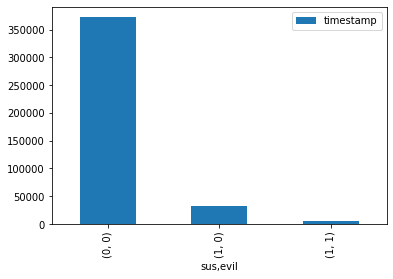

In [93]:
df_process_final.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

<AxesSubplot:>

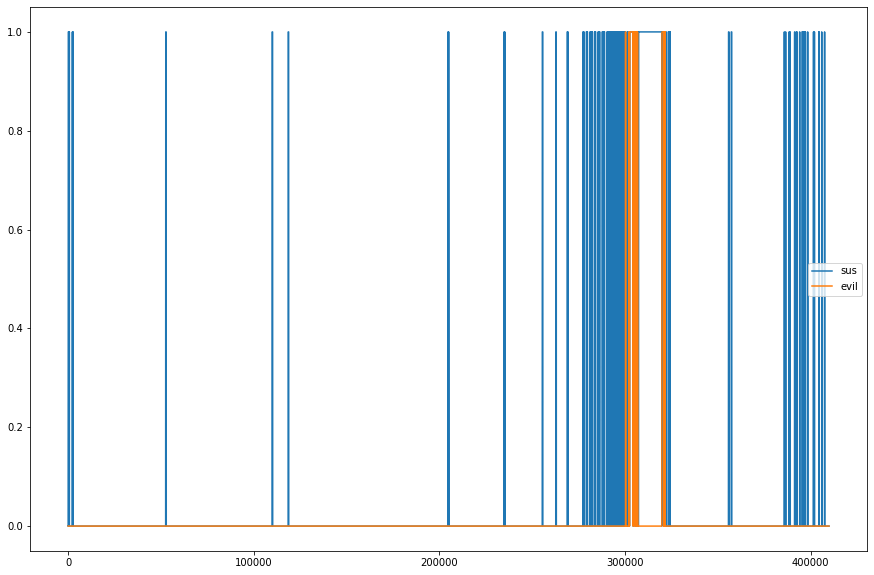

In [94]:
df_process_final[["sus","evil"]].plot(figsize=(15, 10))

<AxesSubplot:>

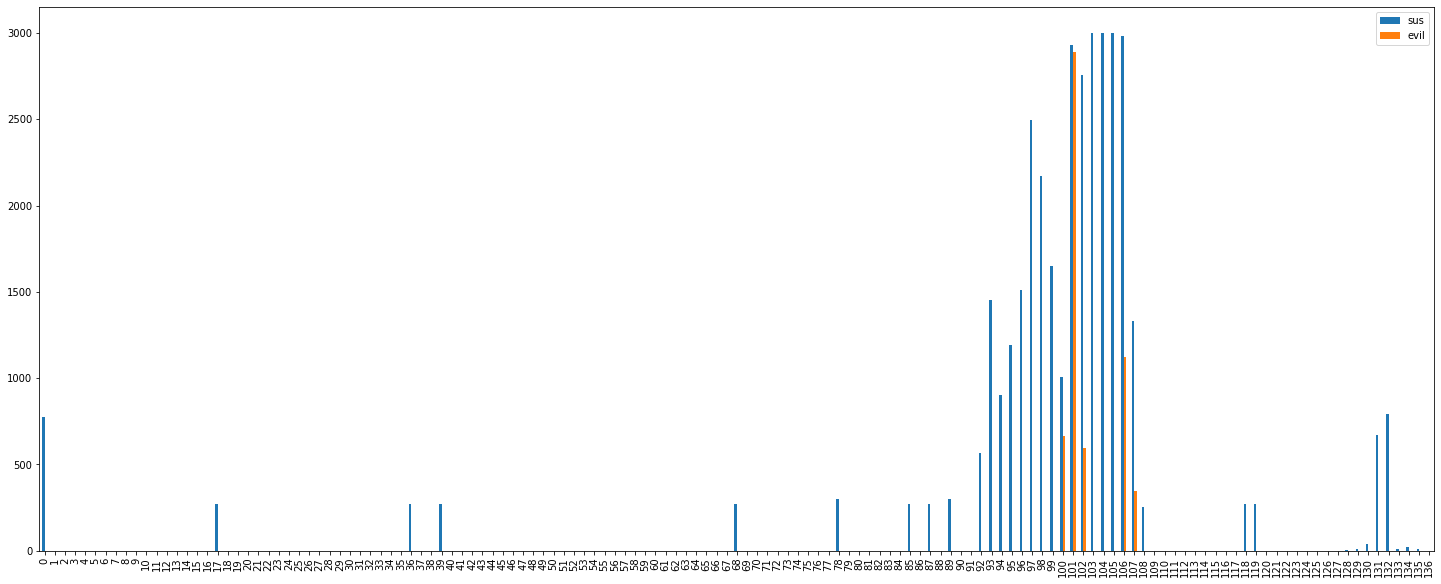

In [95]:
N = 3000
df_process_final[["sus","evil"]].groupby(df_process_final.index // N).sum().plot(kind='bar',figsize=(25, 10))

In [96]:
df_process_final[:2000]

,timestamp,processId,parentProcessId,userId,processName,hostName,eventId,eventName,argsNum,returnValue,args,sus,evil
0,126.233491,1,0,0,systemd,ip-10-100-1-105,1005,security_file_open,4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
1,126.233165,384,1,101,systemd-resolve,ip-10-100-1-105,41,socket,3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
2,126.233559,1,0,0,systemd,ip-10-100-1-105,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 18}, {...",0,0
3,126.233681,1,0,0,systemd,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 18}]",0,0
4,126.233796,384,1,101,systemd-resolve,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 15}]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,143.908889,7306,1218,0,ps,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 9}]",0,0
1996,143.908918,7306,1218,0,ps,ip-10-100-1-105,1005,security_file_open,4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
1997,143.908945,7306,1218,0,ps,ip-10-100-1-105,257,openat,4,9,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
1998,143.908979,7306,1218,0,ps,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 9}]",0,0


## Process Graph

In [97]:
Gp = nx.from_pandas_edgelist(df_process_final[:2000], source="parentProcessId", target="processId", edge_attr=True, create_using=nx.MultiDiGraph())


In [98]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(Gp.nodes))
print("Number of edges: %s\n" % len(Gp.edges))
print("Graph density: %s\n" % nx.density(Gp))
print("Graph is directed: %s\n" % Gp.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(Gp))

Graph analysis

Multi-edge directed Graph

Number of nodes: 24	
Number of edges: 2000

Graph density: 3.6231884057971016

Graph is directed: True

Graph is weighted: False



In [99]:
# Check how many nodes the graph contains to set attributes for figure size
n = len(Gp.nodes)
if n > 1000:
    largegraph=True
    fig_size = (50,40)
    print("Large Graph: %s , using large graph functions" % n)
if n <= 500 > 999:
    fig_size = (40,30)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n <= 250  > 499 :
    fig_size = (30,20)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n < 100 > 0:
    fig_size = (18,15)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))

Small Graph: 24 figsize: (18, 15)


In [100]:
len(Gp.nodes)

24

In [101]:
fig_size = (50,40)

In [102]:
# Draw our graph
#Define our Graph Plot Layouts
def plot_graph(G):
    layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
#     layouts = (nx.spring_layout)

    title = ("Force-directed", "Random", "Spiral", "Circular")
#     title = ("Circular")

    ## Create our Plots
    # Create 4 subplots with the figure size based on graph size
    _, plot = plt.subplots(2, 2, figsize=fig_size)
    subplots = plot.reshape(1, 4)[0]
    # Draw a plot for each layout
    for plot, layout, title in zip(subplots, layouts, title):
        pos = layout(G)
        nx.draw_networkx_edges(G, pos, ax=plot, width=0.5, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
        nx.draw_networkx_nodes(G, pos, ax=plot, node_color="black", node_shape="D")
        # Draw labels
        nx.draw_networkx_labels(G, pos, ax=plot, font_color="red", font_size=18)
        plot.set_title(title)
    # Draw with tight layout https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html
    plt.gca().margins(0.20, 0.20)
    plt.tight_layout()
    plt.show(block=False)
    
    

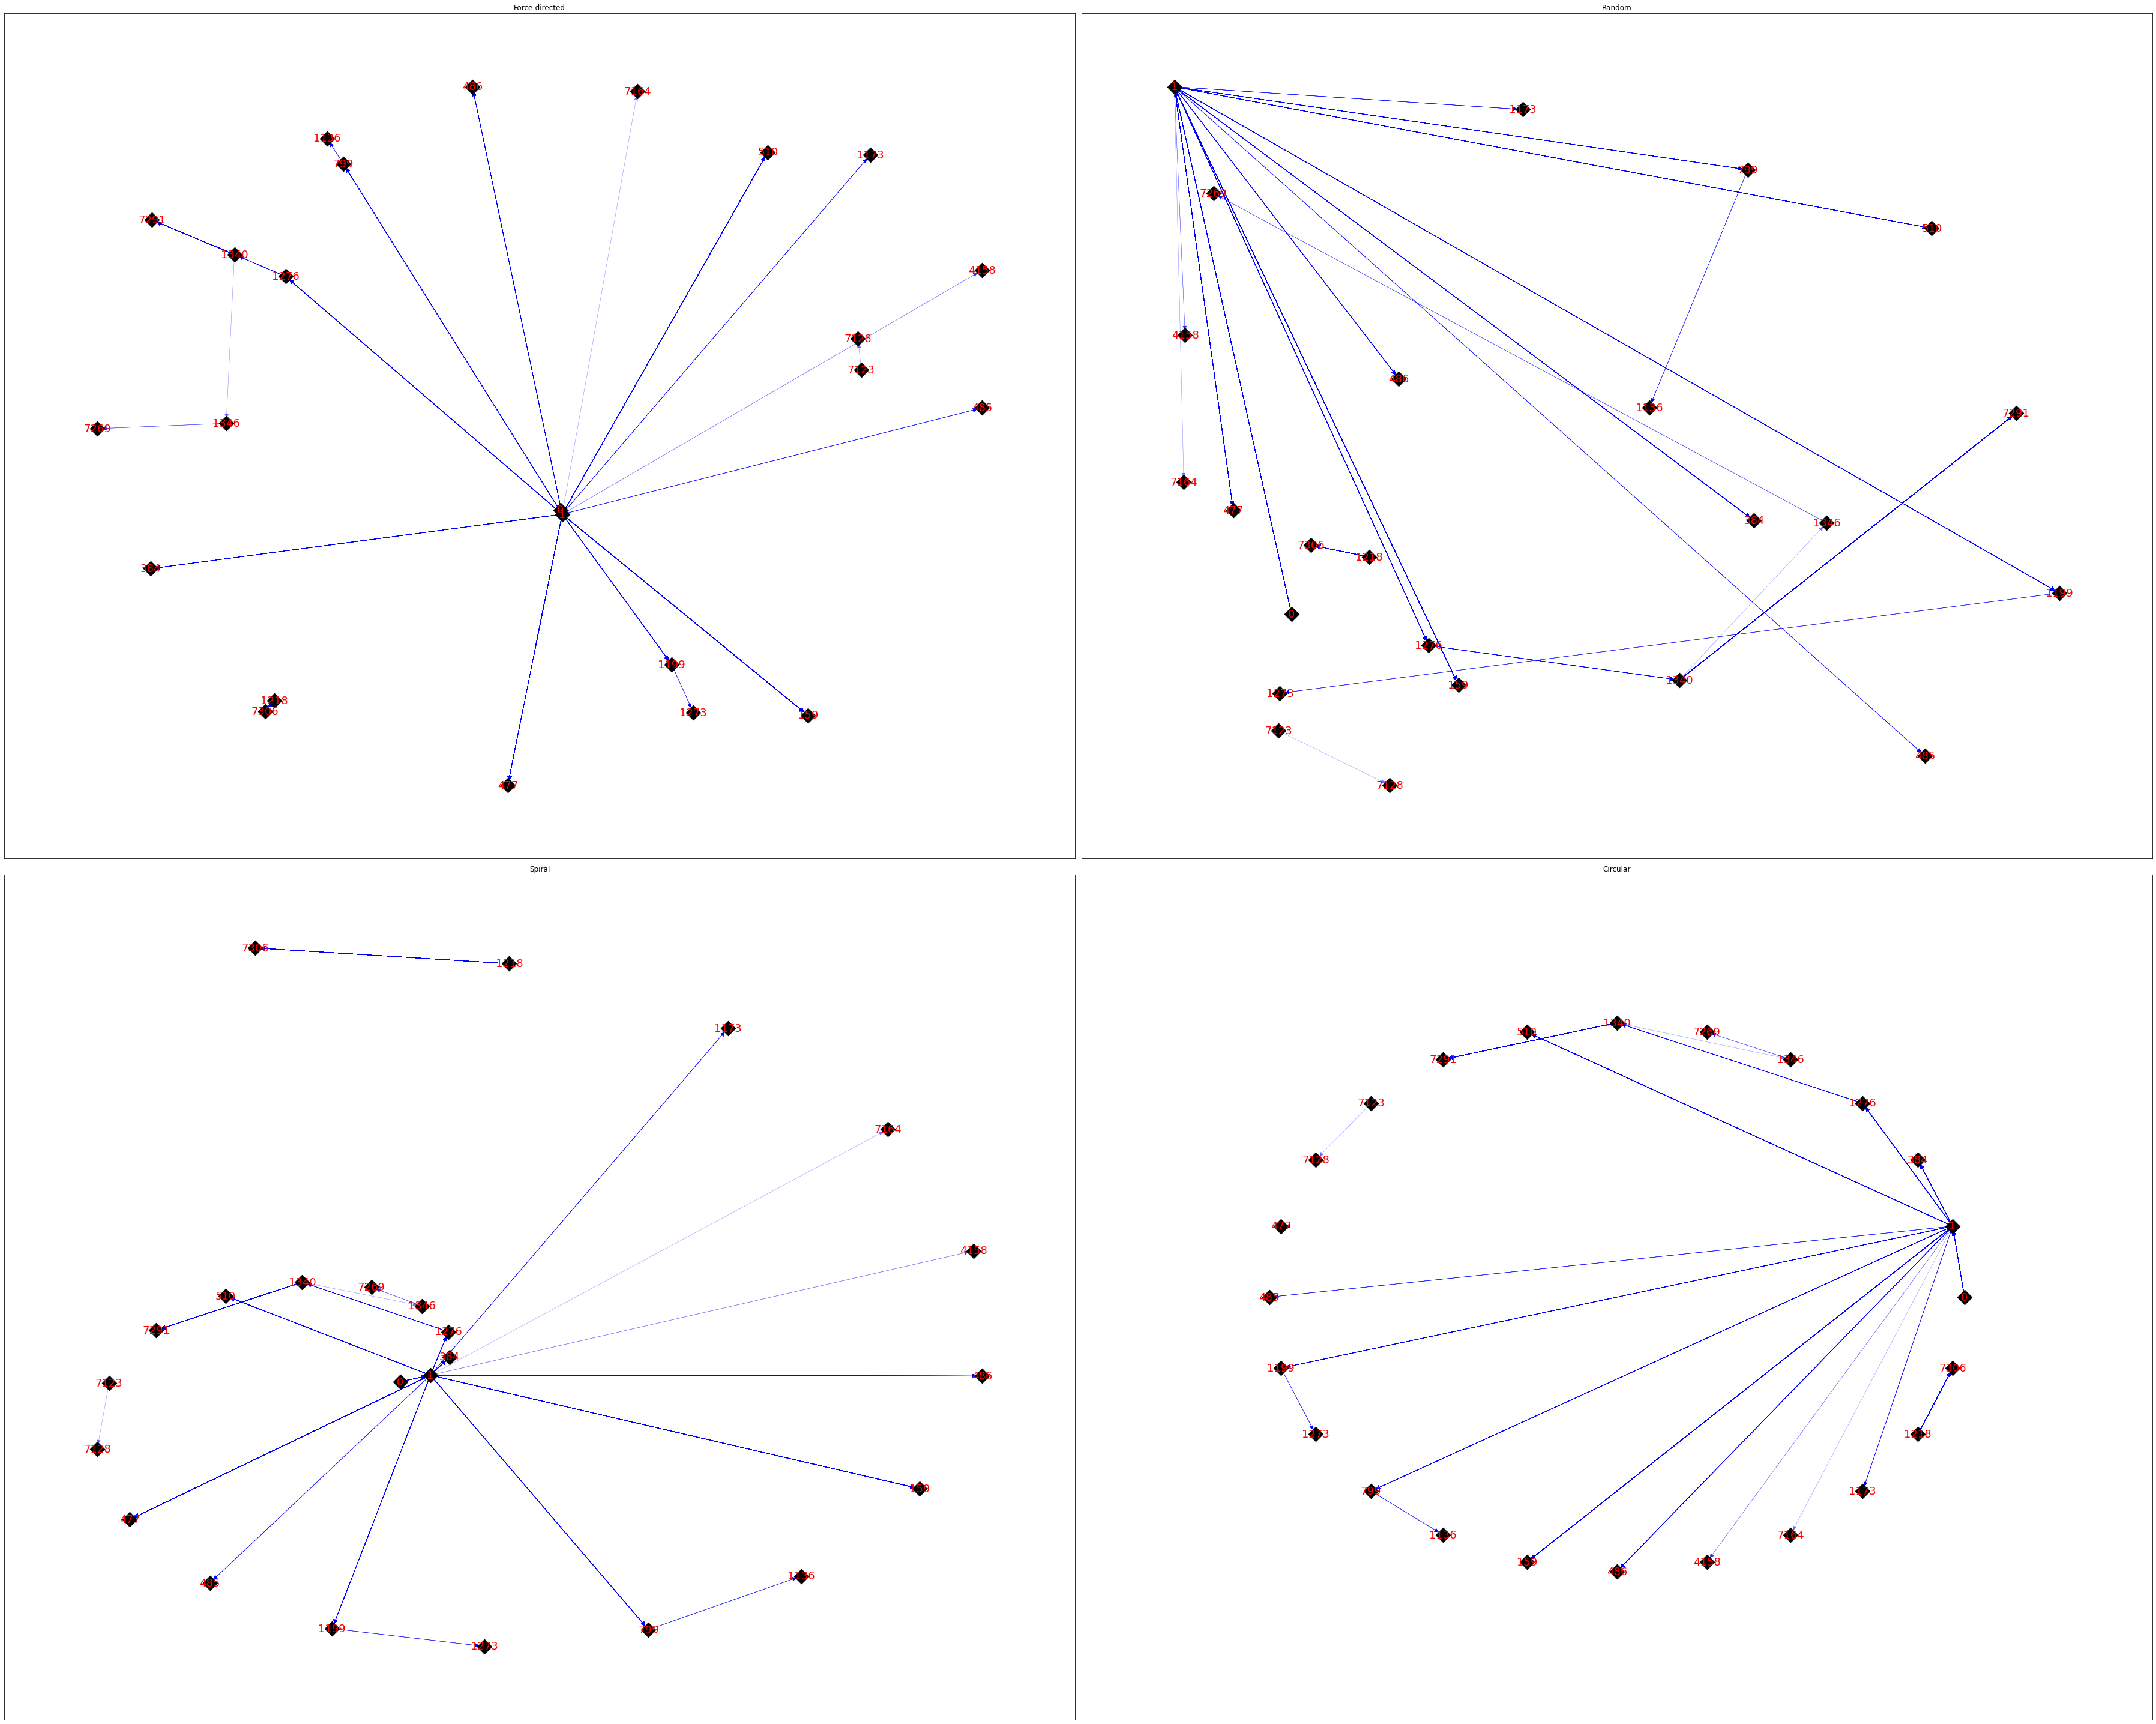

In [103]:
plot_graph(Gp)

### Preprocessing Process Data Based on Paper

In [104]:
df_process_final['processId'] = df_process_final['processId'].apply(lambda x: 1 if x <3 else 0)

In [105]:
df_process_final['parentProcessId'] = df_process_final['parentProcessId'].apply(lambda x: 1 if x <3 else 0)


In [106]:
df_process_final['userId'] = df_process_final['userId'].apply(lambda x: 0 if x <1000 else 1)


In [107]:
df_process_final.head()

,timestamp,processId,parentProcessId,userId,processName,hostName,eventId,eventName,argsNum,returnValue,args,sus,evil
0,126.233491,1,1,0,systemd,ip-10-100-1-105,1005,security_file_open,4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
1,126.233165,0,1,0,systemd-resolve,ip-10-100-1-105,41,socket,3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
2,126.233559,1,1,0,systemd,ip-10-100-1-105,5,fstat,2,0,"[{'name': 'fd', 'type': 'int', 'value': 18}, {...",0,0
3,126.233681,1,1,0,systemd,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 18}]",0,0
4,126.233796,0,1,0,systemd-resolve,ip-10-100-1-105,3,close,1,0,"[{'name': 'fd', 'type': 'int', 'value': 15}]",0,0


## DNS Graph From the data

In [108]:
Gd = nx.from_pandas_edgelist(df_final, source="SourceIP", target="DestinationIP", edge_attr=True, create_using=nx.MultiDiGraph())


In [109]:
src_attributes = [ "DnsQueryClass","DnsQueryType", "sus", "evil"]

# Iterate over df rows and set source node attributes:
for index, row in df_final.iterrows():
#     src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
#     G.nodes[row["SourceIP"]].update(src_attr_dict)
#     G.nodes[row["DestinationIP"]].update(src_attr_dict)
#     print(index)
    pass

In [110]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(Gd.nodes))
print("Number of edges: %s\n" % len(Gd.edges))
print("Graph density: %s\n" % nx.density(Gd))
print("Graph is directed: %s\n" % Gd.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(Gd))


Graph analysis

Multi-edge directed Graph

Number of nodes: 15	
Number of edges: 259

Graph density: 1.2333333333333334

Graph is directed: True

Graph is weighted: False



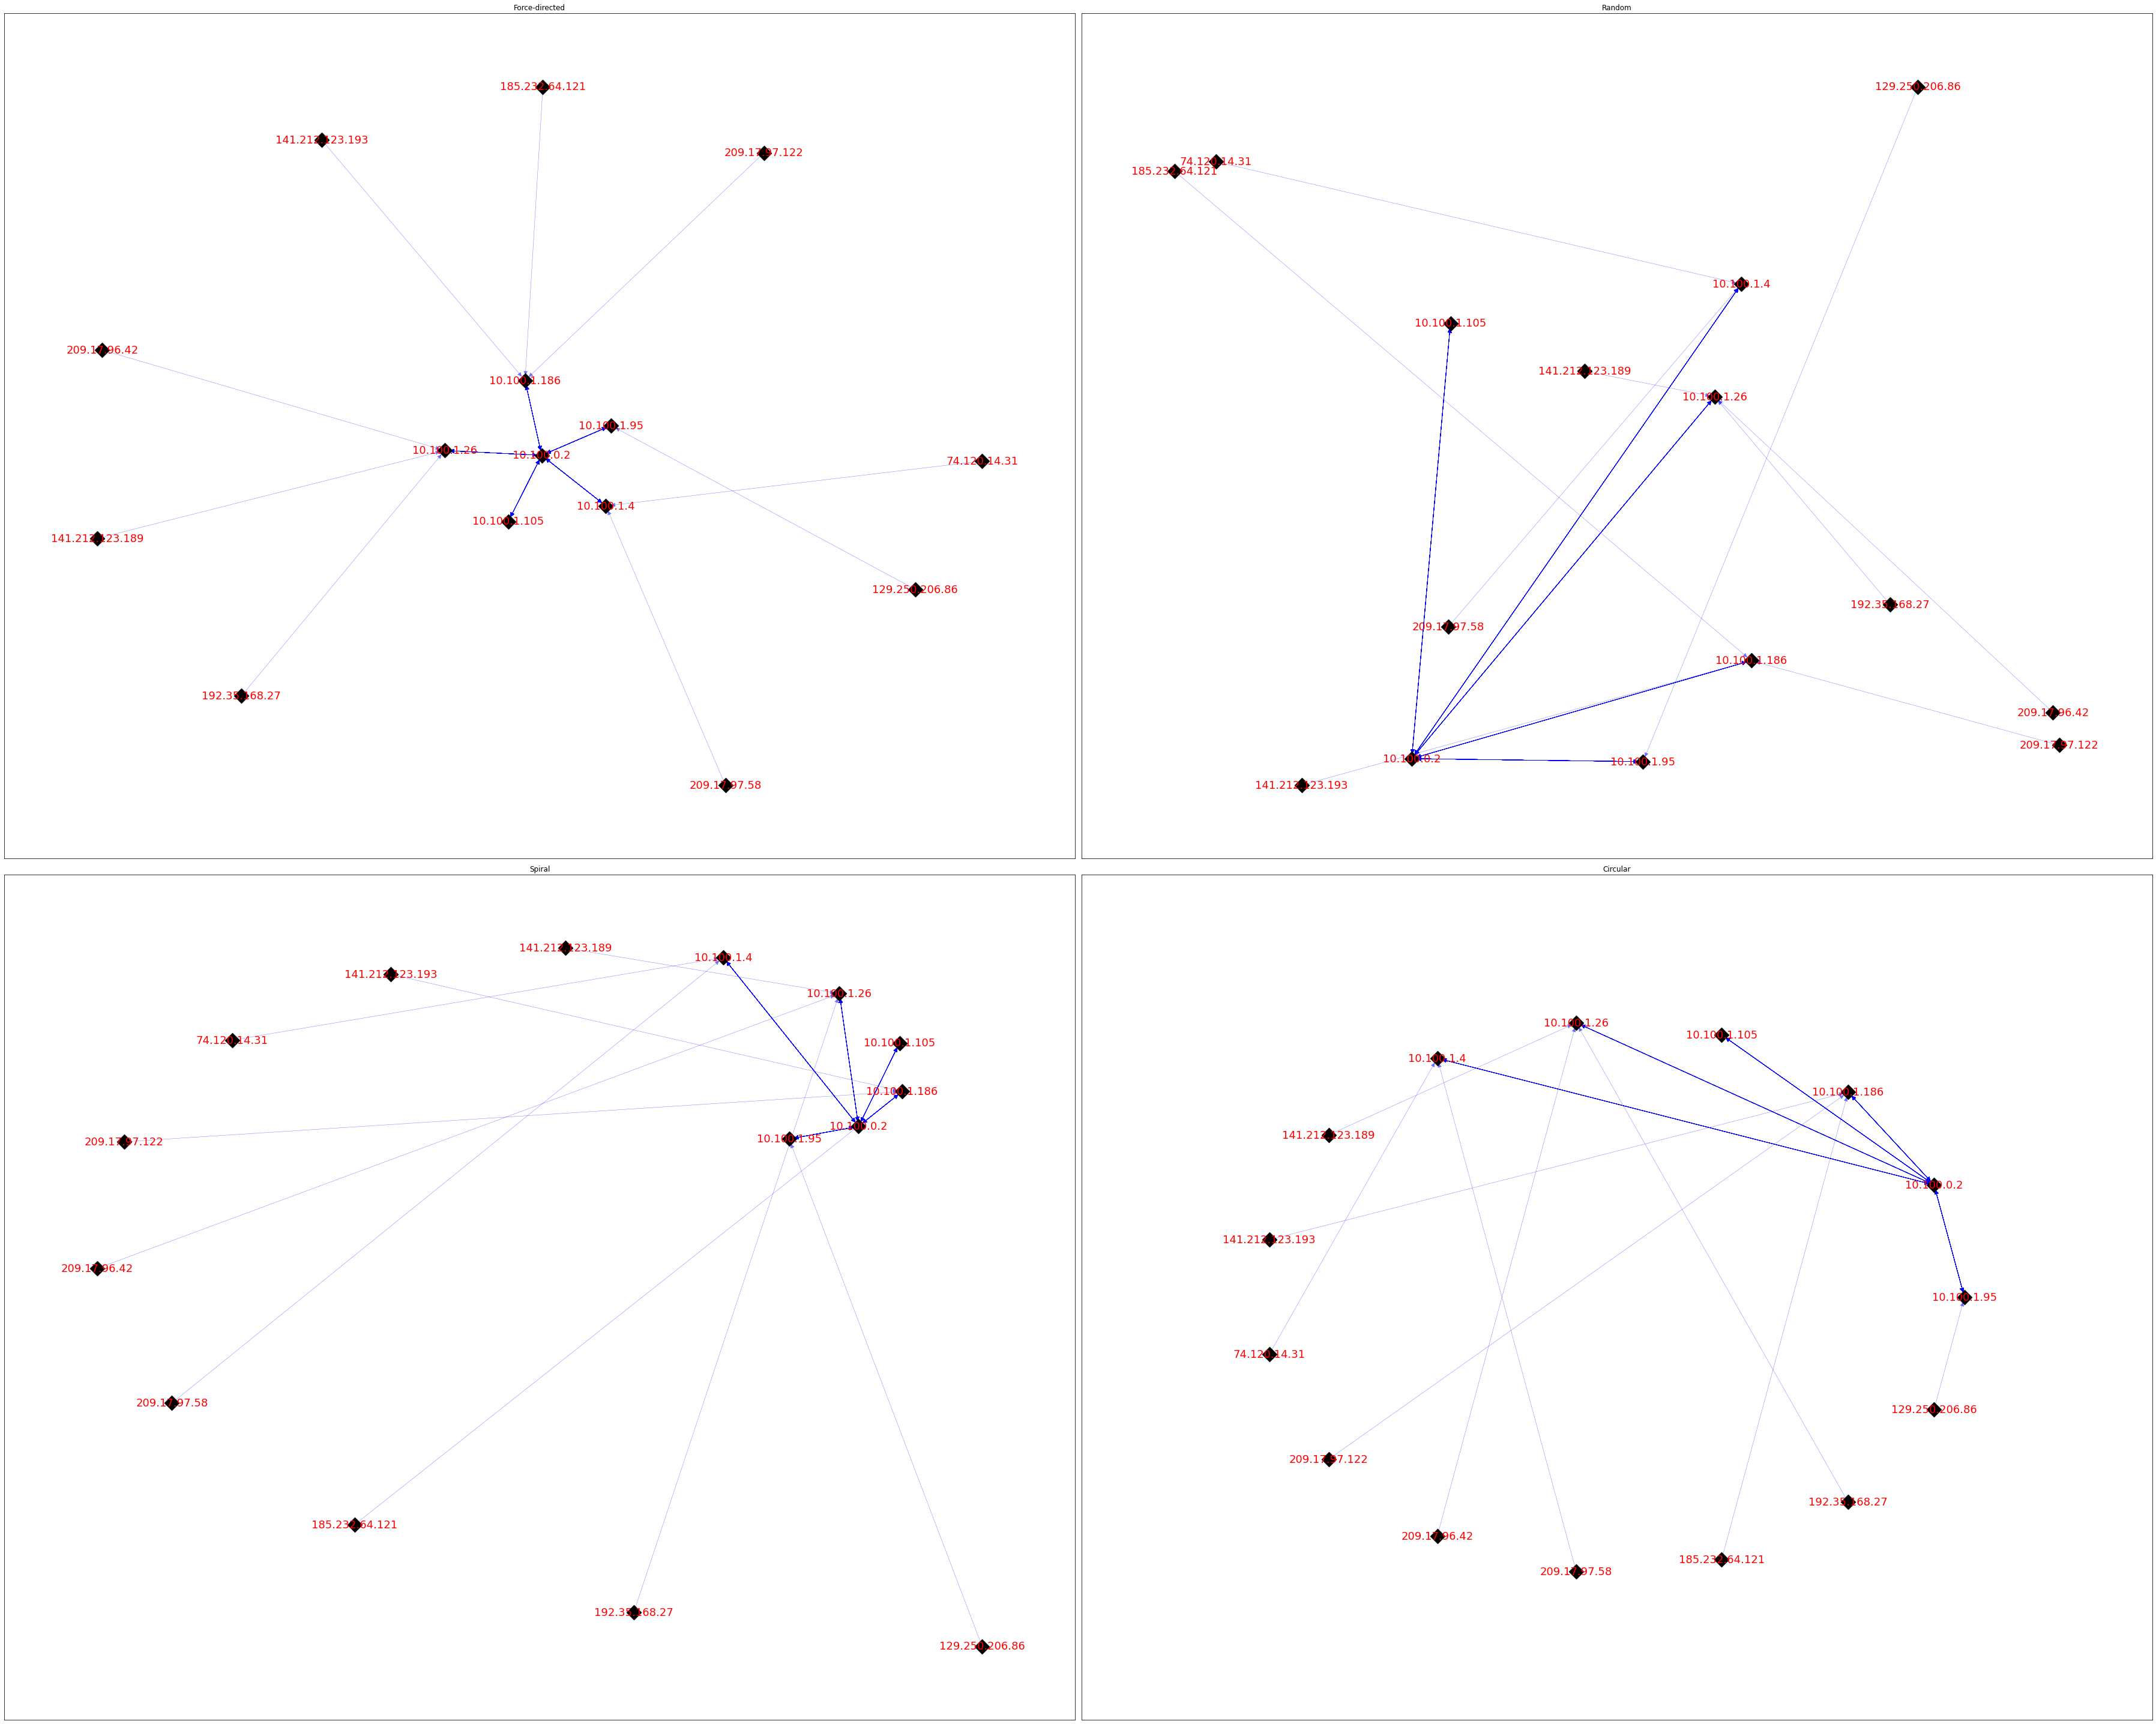

In [111]:
plot_graph(Gd)

# Adding Attributes to Graph

In [112]:
df_final['destination_weight'] = (df_final.groupby(["DestinationIP"])['Timestamp'].transform('nunique'))/df_final.shape[0]

In [113]:
df_final['destination_weight']

0      0.189189
1      0.061776
2      0.189189
3      0.061776
4      0.189189
         ...   
264    0.054054
265    0.189189
266    0.189189
267    0.054054
268    0.054054
Name: destination_weight, Length: 259, dtype: float64

In [114]:
src_attributes = [ "DnsQueryClass","DnsQueryType", "sus", "evil"]

# Iterate over df rows and set source node attributes:
for index, row in df_final.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    Gd.nodes[row["SourceIP"]].update(src_attr_dict)
    Gd.nodes[row["DestinationIP"]].update(src_attr_dict)

src_attributes = ["destination_weight"]
# Iterate over df rows and set source node attributes:
for index, row in df_final.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    Gd.nodes[row["DestinationIP"]].update(src_attr_dict)

In [115]:
private_ips = [ip for ip in Gd.nodes if ipaddress.ip_address(ip).is_private]
global_ips = [ip for ip in list(Gd.nodes) if ipaddress.ip_address(ip).is_global]
reserved_ips = [ip for ip in Gd.nodes if ipaddress.ip_address(ip).is_reserved]

sus_evil_00 = [(u, v) for (u, v, d) in Gd.in_edges(data=True) if (d["sus"] == 0) and (d["evil"] == 0)]
sus_evil_10 = [(u, v) for (u, v, d) in Gd.out_edges(data=True) if (d["sus"] == 1) and (d["evil"] == 0)]
sus_evil_11 = [(u, v) for (u, v, d) in Gd.in_edges(data=True) if (d["sus"] == 1) and (d["evil"] == 1) ]

In [116]:
node_labels = dict([(u, u) for (u, v) in Gd.nodes(data=True)])
node_labels                                   

{'10.100.1.95': '10.100.1.95',
 '10.100.0.2': '10.100.0.2',
 '10.100.1.186': '10.100.1.186',
 '10.100.1.105': '10.100.1.105',
 '10.100.1.26': '10.100.1.26',
 '10.100.1.4': '10.100.1.4',
 '141.212.123.189': '141.212.123.189',
 '141.212.123.193': '141.212.123.193',
 '74.120.14.31': '74.120.14.31',
 '209.17.97.122': '209.17.97.122',
 '209.17.96.42': '209.17.96.42',
 '209.17.97.58': '209.17.97.58',
 '185.232.64.121': '185.232.64.121',
 '192.35.168.27': '192.35.168.27',
 '129.250.206.86': '129.250.206.86'}

In [117]:
node_weights = nx.get_node_attributes(Gd, "destination_weight")


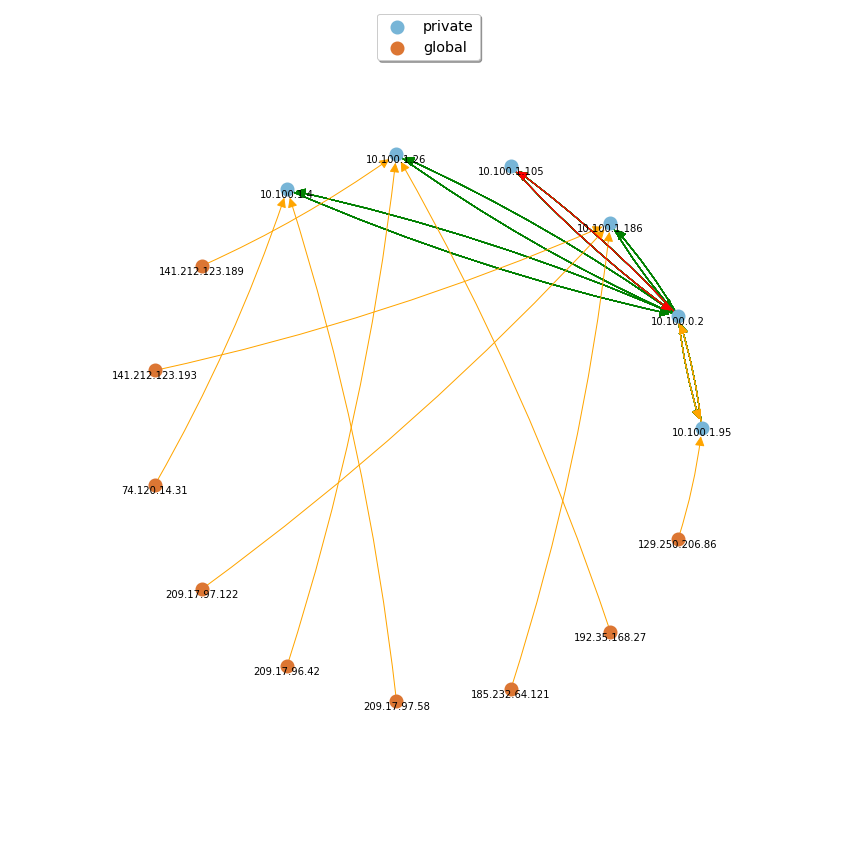

In [118]:
plt.figure(figsize=(12,12))
pos = nx.circular_layout(Gd)

# nx.draw_networkx_nodes(G, 
#                        pos, 
#                        nodelist=node_weights.keys(),
#                        node_color=list(node_weights.values()),
#                        cmap=plt.cm.OrRd,
#                        vmin=0.1,
#                        vmax=10.1,
#                        node_shape='o',
#                        linewidths=4,
#                        alpha=0.2,
#                        node_size=[v * 900 for v in node_weights.values()])

# Draw the type of node on top of each node, for global, private and reserved IP's
nx.draw_networkx_nodes(Gd, 
                       pos, 
                       nodelist=private_ips,
                       node_color='#77B5D7', 
                       node_shape='o',
                       linewidths=4,
                       alpha=1,
                       label='private',
                       node_size=100)
nx.draw_networkx_nodes(Gd, 
                       pos, 
                       nodelist=global_ips, 
                       node_color='#DC7633', 
                       node_shape='o',  
                       linewidths=4,
                       alpha=1,
                       label='global',
                       node_size=100)


nx.draw_networkx_nodes(Gd, 
                       pos, 
                       nodelist=reserved_ips, 
                       node_color='#C0392B', 
                       node_shape='P',  
                       linewidths=4,
                       alpha=1,
                       label='reserved',
                       node_size=100)


# Draw the corresponding labels for each node
# For SUS_EVIL 00
nx.draw_networkx_labels(Gd, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels,
                        font_size=10)



nx.draw_networkx_edges(Gd, 
                       pos, 
                       edgelist=sus_evil_00, 
                       width=1, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='green',
                       alpha=1, 
                       label='00',
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

# nx.draw_networkx_edge_labels(G, 
#                              pos, 
#                              edge_labels=dict(sus_evil_00), 
#                              label_pos=0.9, 
#                              font_color='#229954', 
#                              font_size=8)

nx.draw_networkx_edges(Gd, 
                       pos, 
                       edgelist=sus_evil_10, 
                       width=1, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='orange',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='10',
                       min_source_margin=3.0,
                       min_target_margin=3.0)


nx.draw_networkx_edges(Gd, 
                       pos, 
                       edgelist=sus_evil_11, 
                       width=1, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='red',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='11',
                       min_source_margin=3.0,
                       min_target_margin=3.0)


# For the edge labels we show the count of Suricata alerts




# nx.draw_networkx_edge_labels(G,
#                              pos,
#                              edge_labels=dict(sus_evil_10),
#                              label_pos=0.9,
#                              font_color='#229954',
#                              font_size=8)

# nx.draw_networkx_edge_labels(G,
#                              pos,
#                              edge_labels=dict(sus_evil_11),
#                              label_pos=0.9,
#                              font_color='#229954',
#                              font_size=8)

plt.box()
# Draw legend
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Set margins
plt.gca().margins(0.2, 0.2)
# Set tight layout
plt.tight_layout()
plt.show()

# Interactive Graph

In [46]:

# defaults = dict(width=800, height=600)
# hv.opts.defaults(
#     opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

In [47]:
# G.nodes(data=True) 

In [48]:
# labels = hv.Labels(G.nodes)

# graph = hv.Graph.from_networkx(G, nx.layout.circular_layout).opts(directed=True,tools=['hover'],arrowhead_length=0.02)
# # hv.HoloMap({i: hv.Graph.from_networkx(G, nx.circular_layout, iterations=i, seed=10) for i in range(5, 30, 5)},
# #            kdims='Iterations')
# graph